In [1]:
import os
from datasets import load_dataset
import datasets
from datasets import Value, Sequence
import sys
import math
import transformers
import json
import matplotlib.pyplot as plt

cache_dir = '/users/PDS0352/wyang107/project/LCEG/model_cache/data'

/users/PDS0352/wyang107/miniconda3/envs/lceg2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/PDS0352/wyang107/miniconda3/envs/lceg2/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
# InfiniteBench = load_dataset('xinrongzhang2022/InfiniteBench', cache_dir=cache_dir, streaming= True)
ft = datasets.Features({"id": Value("int64"), "context": Value("string"), "input": Value("string"), "answer": Sequence(Value("string")), "options": Sequence(Value("string"))})
InfiniteBench = load_dataset("xinrongzhang2022/InfiniteBench", features=ft, cache_dir=cache_dir, streaming=True)

In [32]:
tokenizer = transformers.AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')

In [37]:
# 'gsm100'
# 'codeU'
# 'multidoc_qa'  'legal_contract_qa', 'financial_qa', 'natural_question' 'scientific_qa' 
# 'news_summ', 'patent_summ' 'tv_show_summ' 'review_summ',  'meeting_summ' 
dataset = load_dataset('L4NLP/LEval', name='gsm100'  ,split='test', cache_dir=cache_dir, streaming= True)

In [38]:
for data in dataset:
    print(data.keys())
    print(len(data['instructions']), len(data['outputs']), data['evaluation'])
    tokens = tokenizer.encode(data['input'])
    print(len(tokens))
    break

dict_keys(['instructions', 'input', 'outputs', 'source', 'evaluation'])
1 1 exam
5451


In [2]:
paths = {'ntk':'/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/llama2-7b-hf-slimpajama-ntk-32k/result.json', 
         'pi': '/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/llama2-7b-hf-slimpajama-pi-32k/result.json'}
results = dict()
for k,p in paths.items():
    results[k] = json.load(open(p, 'r'))

1. 先用llama 3.2/Qwen2的模型，来验证本身数据集没有问题
    - 预期的效果：模型越大，得分越多；长度越长，得分越少？
    - 可能出现的问题：
        - 模型本身能力特别强或者特别差，看不出差别；metric问题
        - 数据集本身有缺陷，比如multi-doc-qa，模型本身会有先验信息
        - prompt的影响比较大，比如llama2的multi-doc-sum，有时输出是每篇的sum，而不是多篇一起的sum

2. metric   
    - sum和qa用的分别是：rouge_score和qa_f1_score
    - 但是很多文章采用的是model-based metrics

3. 任务
    - 类型目前分为
        - single-doc-qa，multi-doc-qa，single-doc-sum，multi-doc-sum: 带有干扰文章
        - sythetic： passage_count, passage-retrival, counting-stars， passkey
    - 根据基础文章生成不同长度的文章
    - 是否加入过滤操作：
        - 比如在无context和原文context的情况，模型回答是否差别不大，如果不大，说明模型本身带有先验信息，这条数据就不需要统计

4. 都没有问题，则可以开始实验
    - 不同模型，比如gpt，claude， gemini等
    - 不同长文本方法


/tmp/ipykernel_668511/3462462200.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(draw_things.keys()))


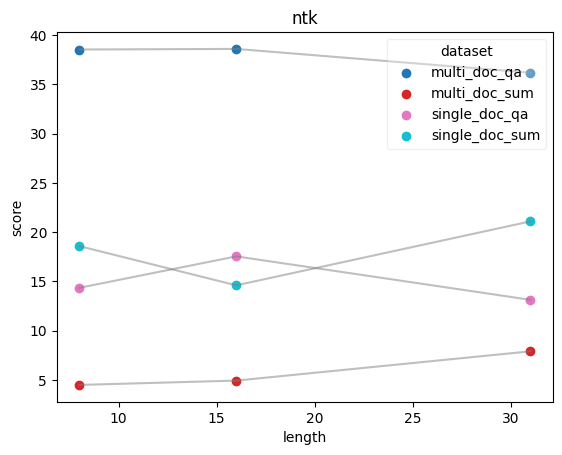

{'multi_doc_qa': [(16, 38.61), (31, 36.2), (8, 38.55)], 'multi_doc_sum': [(16, 4.94), (31, 7.91), (8, 4.5)], 'single_doc_qa': [(16, 17.55), (31, 13.14), (8, 14.36)], 'single_doc_sum': [(16, 14.61), (31, 21.1), (8, 18.59)]}


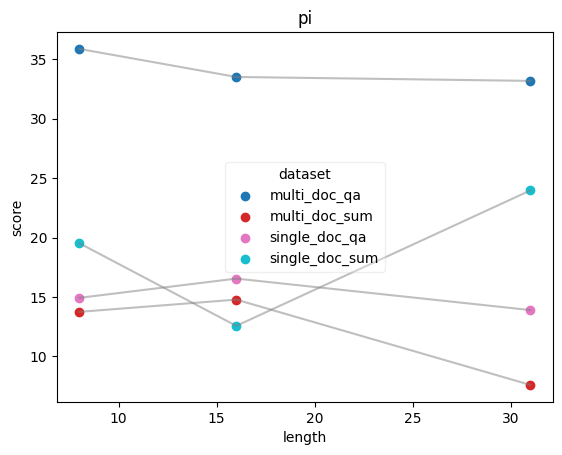

{'multi_doc_qa': [(16, 33.52), (31, 33.19), (8, 35.88)], 'multi_doc_sum': [(16, 14.78), (31, 7.6), (8, 13.75)], 'single_doc_qa': [(16, 16.55), (31, 13.9), (8, 14.93)], 'single_doc_sum': [(16, 12.57), (31, 23.97), (8, 19.52)]}


In [3]:
from collections import defaultdict
for model in results.keys():
    draw_things = defaultdict(list)
    for dataset,score in results[model].items():
        name = dataset.split('_')
        name, x = '_'.join(name[:-1]), int(name[-1])
        draw_things[name].append((x, score))
    draw_things = {key: draw_things[key] for key in sorted(draw_things)}
    # 为每种类型生成不同的颜色
    colors = plt.cm.get_cmap('tab10', len(draw_things.keys()))
    for i, (dataset,scores) in enumerate(draw_things.items()):
        scores = sorted(scores, key=lambda x: x[0])
        x, y = [s_i[0] for s_i in scores], [s_i[1] for s_i in scores]
        # 创建折线图
        plt.plot(x, y, linestyle='-', color='gray', alpha=0.5)  # 绘制灰色折线
        # 绘制每个点，并根据类型分配颜色
        plt.scatter(x, y, color=colors(i), label=dataset)
    plt.legend(loc='best', title="dataset", framealpha=0.3)
    plt.title(model)
    plt.xlabel("length")
    plt.ylabel("score")
    plt.show()
    print(draw_things)


In [24]:
path = {'ntk':'/users/PDS0352/wyang107/project/LCEG/longbench/pred/llama2-7b-hf-slimpajama-ntk-32k/result.json', 
         'pi': '/users/PDS0352/wyang107/project/LCEG/longbench/pred/llama2-7b-hf-slimpajama-pi-32k/result.json'}
results = dict()
for model, p in path.items():
    results[model]= json.load(open(p, 'r'))


In [44]:
from collections import defaultdict
x_map = {'0-2k':2, '2-4k':4, '4-6k':6, '6-8k':8, '8k+':10}
dataset_re = defaultdict(dict)
for model, result in results.items():
    for dataset in result.keys():
        # print(model, dataset, result[dataset])
        for x, res in result[dataset].items():
            if model not in dataset_re[dataset]:
                dataset_re[dataset][model]=[(x_map[x], res['score'], res['num'])]
            else:
                dataset_re[dataset][model].append((x_map[x], res['score'], res['num']))
print(dataset_re['qasper'])

{'ntk': [(2, 0, 0), (4, 35.51, 53), (6, 26.43, 69), (8, 28.64, 55), (10, 23.96, 23)], 'pi': [(2, 0, 0), (4, 28.78, 53), (6, 26.0, 69), (8, 24.57, 55), (10, 25.86, 23)]}


/tmp/ipykernel_1214990/323500725.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


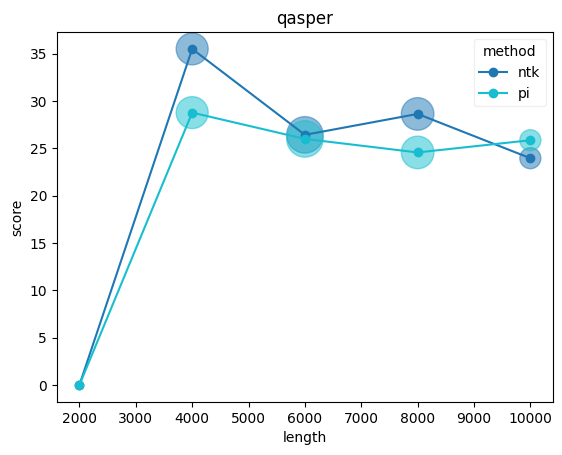

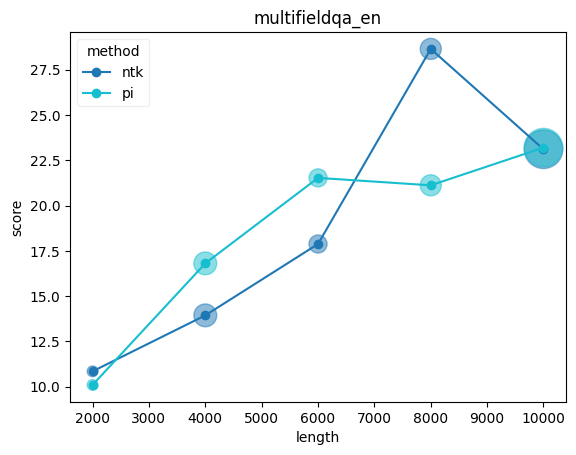

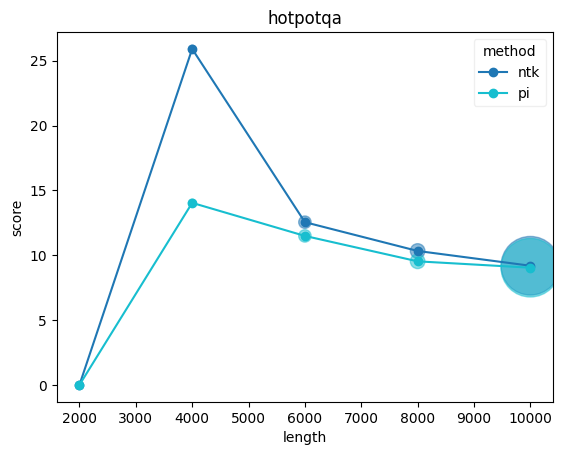

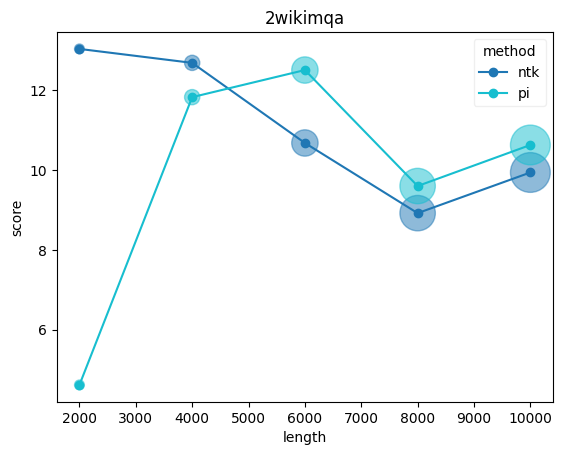

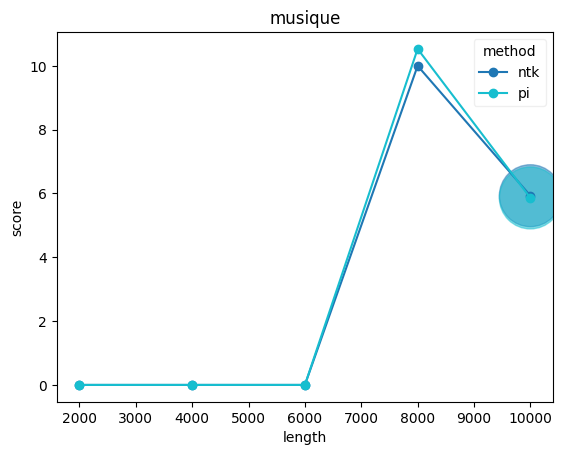

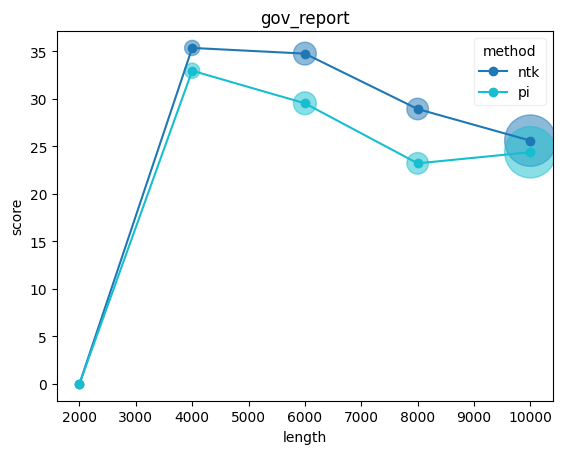

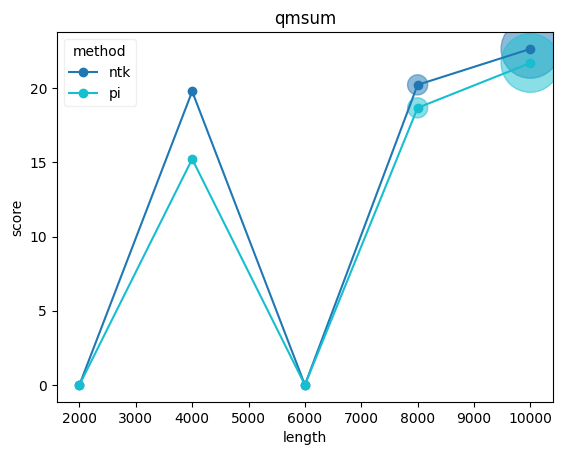

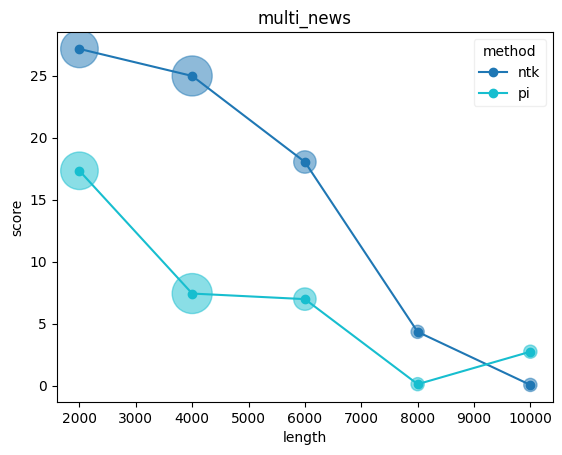

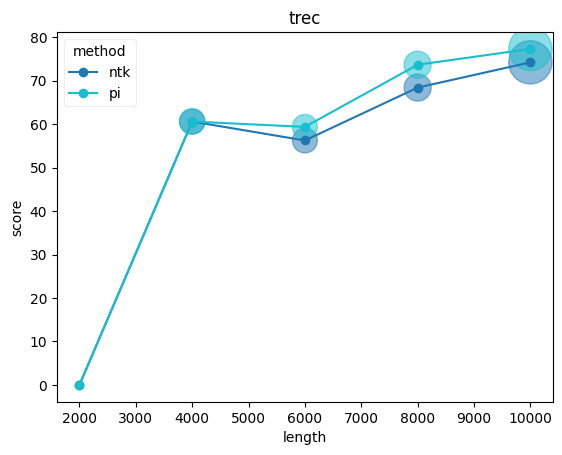

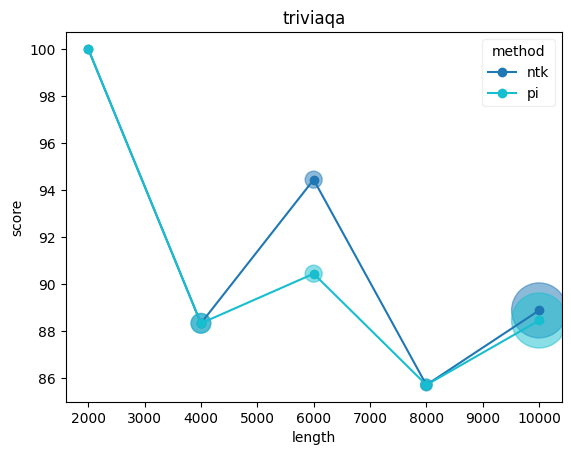

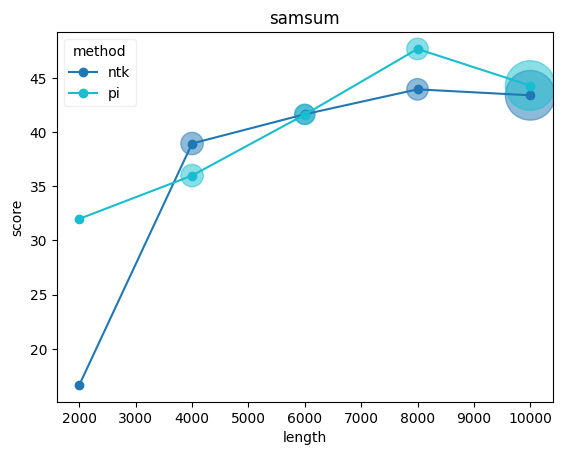

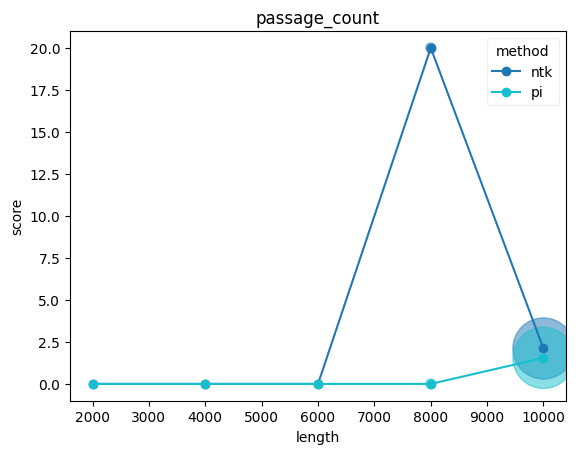

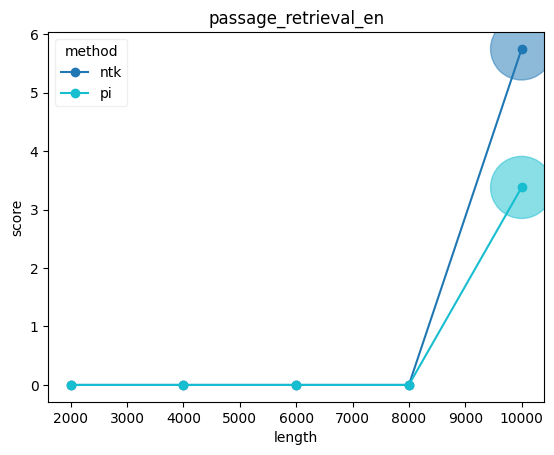

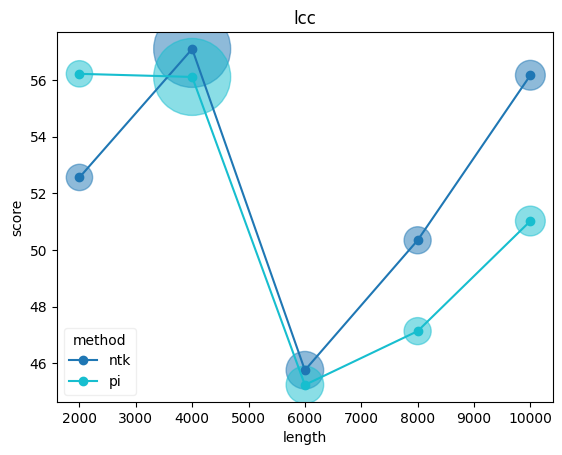

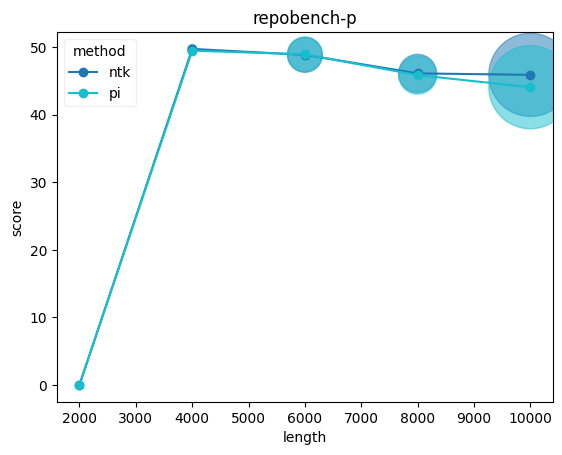

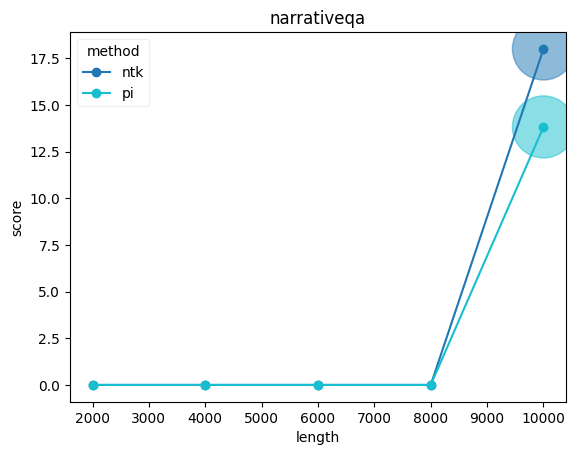

In [46]:
for dataset, model_re in dataset_re.items():
    colors = plt.cm.get_cmap('tab10', len(model_re.keys()))
    for i, (model, res) in enumerate(model_re.items()):
        x, y, sizes = [s[0]*1000 for s in res],[s[1] for s in res],[s[2]*10 for s in res]
        plt.plot(x, y, linestyle='-', marker='o', color=colors(i), label=model) 
        plt.scatter(x, y, s=sizes, color=colors(i), alpha=0.5)
    plt.title(dataset)
    plt.xlabel("length")
    plt.ylabel("score")
    plt.legend(loc='best', title="method", framealpha=0.3)
    plt.show()